# Wet/Dry classification

> This module groups the methods related to wet/dry classification of the CML signal.

In [ ]:
#| default_exp wetdry

In [ ]:
#| export
#| hide
import xarray as xr

In [ ]:
#| hide
import matplotlib.pyplot as plt
from raincell import open_cml_sample, open_gauge_sample
from raincell.data.merge import assign_nearest_gauge_to_link_center

In [ ]:
cml, gauges = open_cml_sample(), open_gauge_sample()

## Adaptation of the Schleiss and Berne (2010) algorithm to NMS min/max sampling

This method was originally designed to work on time-varying attenuation baseline. The main advantage is that it only uses path-integrated attenuation measurements from single-polarization and single frequency commercial microwave links and thus does not need any calibration from external sources such as rain gauges or radars, which makes it very suitable for territories with observation scarcity.

The method relies on the assumption that the variability of the signal is small during dry periods and large during rainy periods.

The method consists of two steps. First, the local variability $S_{W_t}$ is computed for a given moving time window. Second, a variability threshold $\sigma_0$ value is computed. Then:

$$\text{Decision rule: } \begin{cases} 
\text{rain if } S_{W_t} > \sigma_0 \\
\text{dry if } S_{W_t} \leq \sigma_0
\end{cases}$$

The original method was based on a 30-second sampling rate (instantaneous), from which $S_{W_t}$ was calculated for a temporal window of 15 to 35 minutes. This interval was found optimal for capturing rain dynamics. However, when working with NMS min/max sampling, the temporal windows are usually on the order of several minutes. Thus its not possible to calculate variability using the proposed formula. To tackle this issue, we use a simplified version of variability calculated as:

$$
S_{W_t} = TSL_{max} - RSL_{min}
$$

In [ ]:
#| hide
isel = dict(cml_id=0, sublink_id=0) 
sublink = cml.isel(**isel)

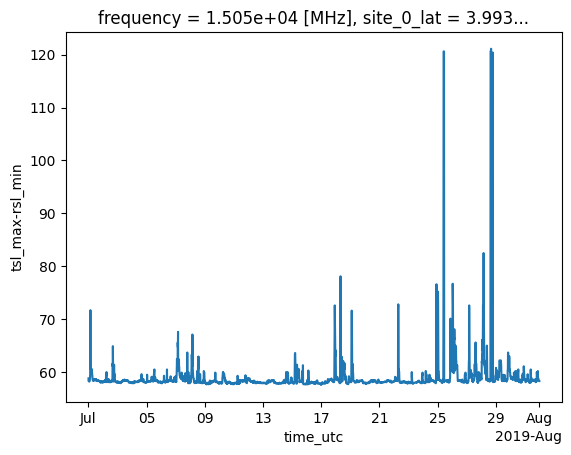

In [ ]:
#| hide
sw = sublink["tsl_max"] - sublink["rsl_min"]
sw.name = "tsl_max-rsl_min"
sw.plot();

Regarding the second step, two methods are proposed depending on the amount of available data. If few data are available, $\sigma_0$ can be estimated based on a collection of non-consecutive dry periods. However, this method requires local measurements to determine which are dry periods, so it is left for future work.

If a large amount of data is available (several months), we can assume that rainy periods represent only a fraction *r* of all the available periods. This fraction will depend on the region, so we recommend studying it for your specific use case. However, a default value of 0.05 to 0.15 (i.e., it rains 5% to 15% of the time) seems coherent with the original paper and our own experience. We will set it to 0.1. As a rule of thumb, a larger *r* will tend to produce more false positives while a smaller *r* will produce more false negatives. Thus, the threshold is computed as:
$$
\sigma_0 = q_{1−r}\{S_{W_t}\} 
$$
where $q_{1−r}$ denotes the $(1 − r)$ quantile.

In [ ]:
#| hide
r = 0.1
sigma0 = sw.quantile(q=(1-r), dim="time")
sigma0

<xarray.DataArray 'tsl_max-rsl_min' ()> Size: 8B
array(59.97)
Coordinates:
    quantile  float64 8B 0.9

In [ ]:
#| hide
wet = sw >= sigma0
wet.drop_vars("quantile")

<xarray.DataArray 'tsl_max-rsl_min' (time: 2964)> Size: 3kB
array([False, False, False, ..., False, False, False], shape=(2964,))
Coordinates:
  * time         (time) datetime64[ns] 24kB 2019-07-01T00:05:00 ... 2019-07-3...
    frequency    float64 8B 1.505e+04
    site_0_lat   float64 8B 3.993
    site_0_lon   float64 8B 9.787
    site_1_lat   float64 8B 3.977
    site_1_lon   float64 8B 9.792
    transmitter  float64 8B 0.0
    length       float64 8B 1.852e+03
    cml_id       <U19 76B '3.984686N-9.789517E'
    sublink_id   <U3 12B '0_0'

In [ ]:
#| export
def schleiss_n_berne_2010_nms_adapted(
        cml: xr.Dataset, # Input CML dataset with tsl_max and rsl_min variables
        r: float = 0.1 # Fraction of time it is assumed to be raining
        ) -> xr.Dataset:
    """ Wet Dry classification algorithm adapted to work with NMS sampling adapted from Schleiss et al., 2010. """
    sw = cml["tsl_max"] - cml["rsl_min"]
    sigma0 = sw.quantile(q=(1-r), dim="time")
    wet = sw >= sigma0
    wet = wet.drop_vars("quantile")
    wet.attrs["long_name"] = "wet_dry_classification"
    wet.attrs["method"] = "schleiss_n_berne_2010_adapted_to_nms_min_max_sampling"
    return wet.to_dataset(name="wet")

In [ ]:
wet_pred = schleiss_n_berne_2010_nms_adapted(cml)
wet_pred

/home/inigo/Documents/1_projects/raincell/.venv/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1617: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


<xarray.Dataset> Size: 2MB
Dimensions:      (cml_id: 126, sublink_id: 6, time: 2964)
Coordinates:
  * cml_id       (cml_id) <U19 10kB '3.984686N-9.789517E' ... '4.095631N-9.74...
  * sublink_id   (sublink_id) <U3 72B '0_0' '0_1' '1_0' '1_1' '2_0' '2_1'
  * time         (time) datetime64[ns] 24kB 2019-07-01T00:05:00 ... 2019-07-3...
    frequency    (cml_id, sublink_id) float64 6kB 1.505e+04 1.456e+04 ... nan
    site_0_lat   (cml_id) float64 1kB 3.993 3.993 3.997 ... 4.087 4.092 4.094
    site_0_lon   (cml_id) float64 1kB 9.787 9.787 9.764 ... 9.766 9.729 9.742
    site_1_lat   (cml_id) float64 1kB 3.977 3.979 3.997 ... 4.095 4.091 4.097
    site_1_lon   (cml_id) float64 1kB 9.792 9.816 9.759 ... 9.764 9.736 9.743
    transmitter  (cml_id, sublink_id) float64 6kB 0.0 1.0 nan ... nan nan nan
    length       (cml_id) float64 1kB 1.852e+03 3.573e+03 556.0 ... 736.0 419.0
Data variables:
    wet          (cml_id, sublink_id, time) bool 2MB False False ... False False

In [ ]:
#| hide
wet_obs = (gauges[["tprate"]] > 0).rename({"tprate": "wet_obs"})

In [ ]:
#| hide
wet_link = assign_nearest_gauge_to_link_center(wet_pred.any(dim="sublink_id"), wet_obs)
wet_link

<xarray.Dataset> Size: 6MB
Dimensions:                  (cml_id: 126, time: 2976)
Coordinates:
  * cml_id                   (cml_id) <U19 10kB '3.984686N-9.789517E' ... '4....
  * time                     (time) datetime64[ns] 24kB 2019-07-01T00:05:00 ....
    site_0_lat               (cml_id) float64 1kB 3.993 3.993 ... 4.092 4.094
    site_0_lon               (cml_id) float64 1kB 9.787 9.787 ... 9.729 9.742
    site_1_lat               (cml_id) float64 1kB 3.977 3.979 ... 4.091 4.097
    site_1_lon               (cml_id) float64 1kB 9.792 9.816 ... 9.736 9.743
    length                   (cml_id) float64 1kB 1.852e+03 3.573e+03 ... 419.0
    gauge_code               (cml_id) int64 1kB 1059095002 ... 1059095005
    gauge_lat                (cml_id) float64 1kB 4.031 4.031 ... 4.057 4.079
    gauge_lon                (cml_id) float64 1kB 9.77 9.77 9.77 ... 9.742 9.768
    gauge_installation_type  (cml_id) <U10 5kB 'Dalle_sol' ... 'Dalle_sol'
    gauge_name               (cml_id) <U25 13kB 'Lycee_NYALLA' ... 'Hopital_d...
Data variables:
    wet                      (cml_id, time) float64 3MB 0.0 0.0 0.0 ... 0.0 0.0
    wet_obs                  (cml_id, time) float64 3MB 0.0 0.0 0.0 ... nan nan

In [ ]:
miss_link = (wet_link.wet - wet_link.wet_obs).dropna(dim="time")
miss_link

<xarray.DataArray (cml_id: 126, time: 2869)> Size: 3MB
array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  1.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0., -1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., -1.]], shape=(126, 2869))
Coordinates:
  * cml_id                   (cml_id) <U19 10kB '3.984686N-9.789517E' ... '4....
  * time                     (time) datetime64[ns] 23kB 2019-07-01T00:05:00 ....
    site_0_lat               (cml_id) float64 1kB 3.993 3.993 ... 4.092 4.094
    site_0_lon               (cml_id) float64 1kB 9.787 9.787 ... 9.729 9.742
    site_1_lat               (cml_id) float64 1kB 3.977 3.979 ... 4.091 4.097
    site_1_lon               (cml_id) float64 1kB 9.792 9.816 ... 9.736 9.743
    length                   (cml_id) float64 1kB 1.852e+03 3.573e+03 ... 419.0
    gauge_code               (cml_id) int64 1kB 1059095002 ... 1059095005
    gauge_lat                (cml_id) float64 1kB 4.031 4.031 ... 4.057 4.079
    gauge_lon                (cml_id) float64 1kB 9.77 9.77 9.77 ... 9.742 9.768
    gauge_installation_type  (cml_id) <U10 5kB 'Dalle_sol' ... 'Dalle_sol'
    gauge_name               (cml_id) <U25 13kB 'Lycee_NYALLA' ... 'Hopital_d...

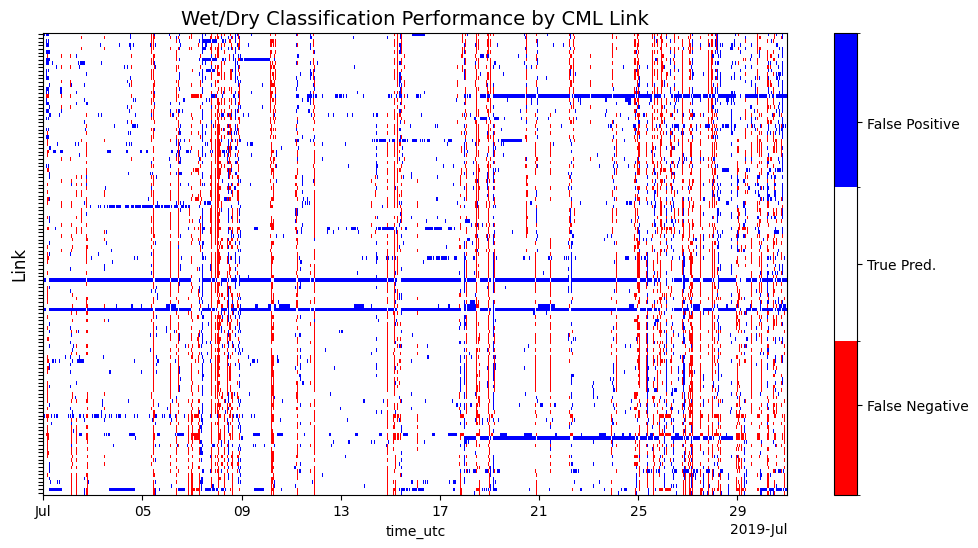

In [ ]:
#| hide
fig, ax = plt.subplots(figsize=(12, 6))
im = miss_link.plot.imshow(x="time", y="cml_id", cmap="bwr_r", robust=True, ax=ax, levels=[-1.1, -0.5, 0.5, 1.1])
# ax.set_yticks([i - 0.5 for i in range(1, miss_link.sizes["cml_id"])])
ax.set_yticklabels([])
# ax.grid(True, axis='y', alpha=1)
cbar = im.colorbar
cbar.set_ticks([-0.75, 0, 0.75])
cbar.set_ticklabels(['False Negative', 'True Pred.', 'False Positive'])
ax.set_title('Wet/Dry Classification Performance by CML Link', fontsize=14)
ax.set_ylabel('Link', fontsize=12);

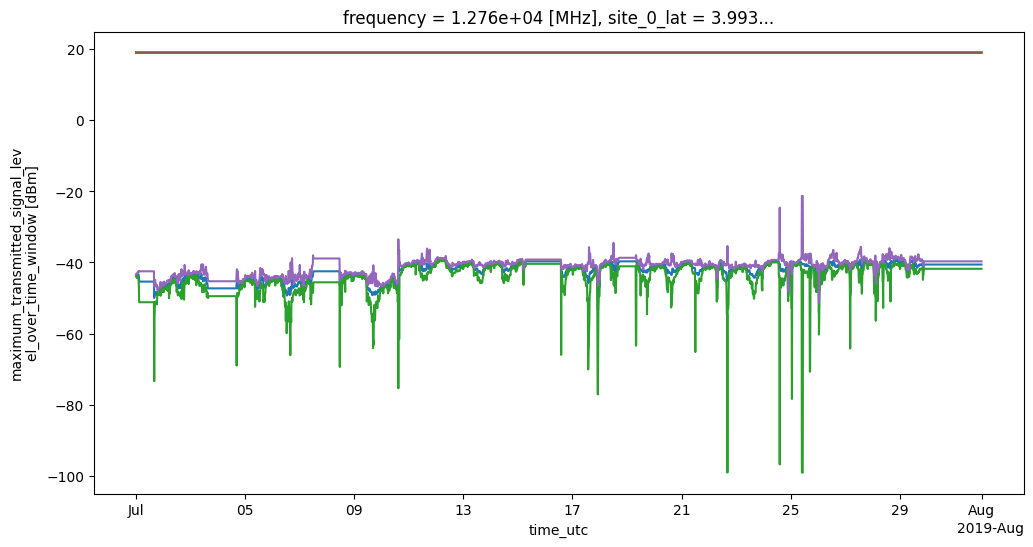

In [ ]:
#| hide
_ = cml.sel(cml_id=miss_link.cml_id[miss_link.mean("time") > 0.05]).isel(cml_id=0, sublink_id=0)
fig, ax = plt.subplots(figsize=(12, 6))
for v in _.data_vars:
    _[v].plot(ax=ax)

<matplotlib.collections.FillBetweenPolyCollection>

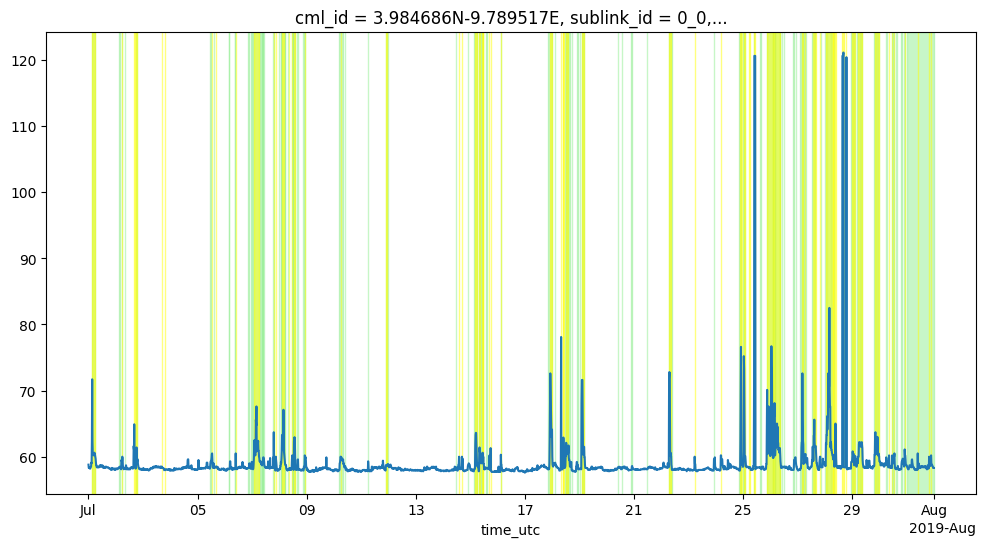

In [ ]:
#| hide
wet_sublinks = assign_nearest_gauge_to_link_center(wet_pred, wet_obs)
ms = xr.merge([cml, wet_sublinks], join="outer") # multisensor dataset
sl = ms.isel(**isel)
fig, ax = plt.subplots(figsize=(12, 6))
(sl["tsl_max"] - sl["rsl_min"]).plot(ax=ax)
ax.fill_between(sl["time"], 0, 1, where=sl["wet_obs"], color='lightgreen', alpha=0.5, transform=ax.get_xaxis_transform())
ax.fill_between(sl["time"], 0, 1, where=sl["wet"], color='yellow', alpha=0.5, transform=ax.get_xaxis_transform())

### References

- Schleiss, M., & Berne, A. (2010). Identification of dry and rainy periods using telecommunication microwave links. IEEE Geoscience and Remote Sensing Letters, 7(3), 611‑615. https://doi.org/10.1109/LGRS.2010.2043052


In [ ]:
#| hide
# fig, ax = plt.subplots(figsize=(12, 6))
# for v in sublink.data_vars:
#     if "tsl" in v.lower() or "rsl" in v.lower():
#         sublink[v].plot(ax=ax, label=v)
# ax.fill_between(tprate["time"], 0, float(ax.get_ylim()[1]), where=tprate > 0, color='lightblue', alpha=0.4, transform=ax.get_xaxis_transform())

# ax.legend()
# plt.show()